## Springboard Data Science Track Capstone Project 2
### Music Genre Classification from Audio Samples
### by Morgan Fry
### Extended Modeling -- LSTM Neural Net

In [1]:
import numpy as np

import matplotlib.pyplot as plt  
%matplotlib inline
import pickle
import utils

#import keras
#from keras.layers import Activation, Dense, Conv1D, Conv2D, MaxPooling1D, Flatten, Reshape, Dropout
#from keras.models import Sequential

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

from sklearn.metrics import classification_report

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)
else:
    print('no gpu')

In [3]:
X_train, X_val, X_test, y_train, y_val, y_test = utils.load_mfcc()

In [4]:
tf.keras.backend.clear_session()

model = models.Sequential()

model.add(layers.Reshape((968,24),input_shape=(X_train.shape[1],)))

model.add(layers.LSTM(units=32, dropout=0.1, return_sequences=True))

model.add(layers.LSTM(units=32, dropout=0.2, return_sequences=False))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))

model.add(layers.Dense(8, activation='softmax'))

loss=tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.0, nesterov=True)
#optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True)
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 968, 24)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 968, 32)           7296      
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
flatten (Flatten)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                2112      
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 520       
Total params: 18,248
Trainable params: 18,248
Non-trainable params: 0
____________________________________________________

In [5]:
%%time

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                              min_delta=0.0001,
                                              patience=100,
                                              restore_best_weights=True)

with tf.device('/GPU:0'):
    history=model.fit(X_train,
              y_train,
              epochs=500,
              batch_size=16,
              callbacks=[early_stop],
              validation_data=(X_val, y_val))

Epoch 1/500
395/395 [==============================] - 14s 35ms/step - loss: 2.0715 - accuracy: 0.1382 - val_loss: 2.0545 - val_accuracy: 0.1778
Epoch 2/500
395/395 [==============================] - 13s 33ms/step - loss: 2.0443 - accuracy: 0.1800 - val_loss: 2.0384 - val_accuracy: 0.1892
Epoch 3/500
395/395 [==============================] - 13s 34ms/step - loss: 2.0315 - accuracy: 0.1819 - val_loss: 2.0311 - val_accuracy: 0.1917
Epoch 4/500
395/395 [==============================] - 13s 33ms/step - loss: 2.0243 - accuracy: 0.1816 - val_loss: 2.0265 - val_accuracy: 0.1917
Epoch 5/500
395/395 [==============================] - 13s 34ms/step - loss: 2.0191 - accuracy: 0.1881 - val_loss: 2.0222 - val_accuracy: 0.1892
Epoch 6/500
395/395 [==============================] - 13s 33ms/step - loss: 2.0140 - accuracy: 0.1905 - val_loss: 2.0142 - val_accuracy: 0.1917
Epoch 7/500
395/395 [==============================] - 13s 34ms/step - loss: 2.0041 - accuracy: 0.1964 - val_loss: 2.0013 - val_ac

395/395 [==============================] - 13s 34ms/step - loss: 1.9406 - accuracy: 0.2431 - val_loss: 1.9224 - val_accuracy: 0.2547
Epoch 58/500
395/395 [==============================] - 14s 35ms/step - loss: 1.9218 - accuracy: 0.2507 - val_loss: 1.8432 - val_accuracy: 0.2762
Epoch 59/500
395/395 [==============================] - 14s 34ms/step - loss: 1.8836 - accuracy: 0.2732 - val_loss: 1.8152 - val_accuracy: 0.3001
Epoch 60/500
395/395 [==============================] - 14s 34ms/step - loss: 1.8713 - accuracy: 0.2868 - val_loss: 1.8300 - val_accuracy: 0.2976
Epoch 61/500
395/395 [==============================] - 14s 34ms/step - loss: 1.8817 - accuracy: 0.2794 - val_loss: 1.7828 - val_accuracy: 0.3342
Epoch 62/500
395/395 [==============================] - 13s 34ms/step - loss: 1.9557 - accuracy: 0.2418 - val_loss: 1.9270 - val_accuracy: 0.2711
Epoch 63/500
395/395 [==============================] - 14s 35ms/step - loss: 1.9480 - accuracy: 0.2418 - val_loss: 1.8996 - val_accuracy

395/395 [==============================] - 13s 32ms/step - loss: 1.8633 - accuracy: 0.2911 - val_loss: 1.8078 - val_accuracy: 0.3304
Epoch 114/500
395/395 [==============================] - 13s 32ms/step - loss: 1.8516 - accuracy: 0.2946 - val_loss: 1.7824 - val_accuracy: 0.3052
Epoch 115/500
395/395 [==============================] - 13s 33ms/step - loss: 1.8159 - accuracy: 0.3122 - val_loss: 1.7407 - val_accuracy: 0.3607
Epoch 116/500
395/395 [==============================] - 13s 32ms/step - loss: 1.8341 - accuracy: 0.3074 - val_loss: 1.9470 - val_accuracy: 0.2383
Epoch 117/500
395/395 [==============================] - 13s 34ms/step - loss: 1.8897 - accuracy: 0.2762 - val_loss: 1.8909 - val_accuracy: 0.2812
Epoch 118/500
395/395 [==============================] - 13s 33ms/step - loss: 1.9032 - accuracy: 0.2705 - val_loss: 1.8872 - val_accuracy: 0.2837
Epoch 119/500
395/395 [==============================] - 13s 32ms/step - loss: 1.9002 - accuracy: 0.2729 - val_loss: 1.8610 - val_ac

Epoch 169/500
395/395 [==============================] - 13s 34ms/step - loss: 1.7756 - accuracy: 0.3333 - val_loss: 1.7183 - val_accuracy: 0.3632
Epoch 170/500
395/395 [==============================] - 12s 32ms/step - loss: 1.7631 - accuracy: 0.3406 - val_loss: 1.6971 - val_accuracy: 0.3745
Epoch 171/500
395/395 [==============================] - 13s 33ms/step - loss: 1.7534 - accuracy: 0.3399 - val_loss: 1.6869 - val_accuracy: 0.3909
Epoch 172/500
395/395 [==============================] - 13s 33ms/step - loss: 1.7424 - accuracy: 0.3409 - val_loss: 1.6937 - val_accuracy: 0.3796
Epoch 173/500
395/395 [==============================] - 13s 33ms/step - loss: 1.7292 - accuracy: 0.3509 - val_loss: 1.7274 - val_accuracy: 0.3632
Epoch 174/500
395/395 [==============================] - 13s 33ms/step - loss: 1.7272 - accuracy: 0.3460 - val_loss: 1.6926 - val_accuracy: 0.3909
Epoch 175/500
395/395 [==============================] - 13s 33ms/step - loss: 1.7228 - accuracy: 0.3480 - val_loss: 1

Epoch 225/500
395/395 [==============================] - 13s 33ms/step - loss: 1.5716 - accuracy: 0.4149 - val_loss: 1.6199 - val_accuracy: 0.4124
Epoch 226/500
395/395 [==============================] - 13s 32ms/step - loss: 1.5734 - accuracy: 0.4239 - val_loss: 1.5609 - val_accuracy: 0.4313
Epoch 227/500
395/395 [==============================] - 13s 33ms/step - loss: 1.5702 - accuracy: 0.4230 - val_loss: 1.5567 - val_accuracy: 0.4388
Epoch 228/500
395/395 [==============================] - 13s 33ms/step - loss: 1.5703 - accuracy: 0.4214 - val_loss: 1.5549 - val_accuracy: 0.4388
Epoch 229/500
395/395 [==============================] - 13s 33ms/step - loss: 1.5661 - accuracy: 0.4214 - val_loss: 1.5578 - val_accuracy: 0.4351
Epoch 230/500
395/395 [==============================] - 13s 33ms/step - loss: 1.5700 - accuracy: 0.4209 - val_loss: 1.5568 - val_accuracy: 0.4477
Epoch 231/500
395/395 [==============================] - 13s 33ms/step - loss: 1.5633 - accuracy: 0.4174 - val_loss: 1

Epoch 281/500
395/395 [==============================] - 13s 32ms/step - loss: 1.5065 - accuracy: 0.4471 - val_loss: 1.5296 - val_accuracy: 0.4388
Epoch 282/500
395/395 [==============================] - 13s 34ms/step - loss: 1.5029 - accuracy: 0.4506 - val_loss: 1.5392 - val_accuracy: 0.4288
Epoch 283/500
395/395 [==============================] - 13s 33ms/step - loss: 1.4985 - accuracy: 0.4482 - val_loss: 1.5178 - val_accuracy: 0.4338
Epoch 284/500
395/395 [==============================] - 13s 34ms/step - loss: 1.5061 - accuracy: 0.4474 - val_loss: 1.5484 - val_accuracy: 0.4338
Epoch 285/500
395/395 [==============================] - 13s 33ms/step - loss: 1.4936 - accuracy: 0.4574 - val_loss: 1.5114 - val_accuracy: 0.4691
Epoch 286/500
395/395 [==============================] - 13s 34ms/step - loss: 1.4937 - accuracy: 0.4561 - val_loss: 1.6009 - val_accuracy: 0.4224
Epoch 287/500
395/395 [==============================] - 13s 33ms/step - loss: 1.4951 - accuracy: 0.4528 - val_loss: 1

Epoch 337/500
395/395 [==============================] - 13s 33ms/step - loss: 1.4304 - accuracy: 0.4764 - val_loss: 1.5487 - val_accuracy: 0.4451
Epoch 338/500
395/395 [==============================] - 13s 34ms/step - loss: 1.4304 - accuracy: 0.4754 - val_loss: 1.5418 - val_accuracy: 0.4363
Epoch 339/500
395/395 [==============================] - 13s 33ms/step - loss: 1.4313 - accuracy: 0.4773 - val_loss: 1.5755 - val_accuracy: 0.4477
Epoch 340/500
395/395 [==============================] - 13s 32ms/step - loss: 1.4265 - accuracy: 0.4780 - val_loss: 1.5453 - val_accuracy: 0.4451
Epoch 341/500
395/395 [==============================] - 13s 33ms/step - loss: 1.4285 - accuracy: 0.4786 - val_loss: 1.5166 - val_accuracy: 0.4477
Epoch 342/500
395/395 [==============================] - 13s 33ms/step - loss: 1.4283 - accuracy: 0.4797 - val_loss: 1.5345 - val_accuracy: 0.4401
Epoch 343/500
395/395 [==============================] - 13s 33ms/step - loss: 1.4192 - accuracy: 0.4842 - val_loss: 1

Epoch 393/500
395/395 [==============================] - 13s 34ms/step - loss: 1.3486 - accuracy: 0.5095 - val_loss: 1.5698 - val_accuracy: 0.4641
Epoch 394/500
395/395 [==============================] - 13s 33ms/step - loss: 1.3540 - accuracy: 0.5073 - val_loss: 1.5800 - val_accuracy: 0.4527
Epoch 395/500
395/395 [==============================] - 13s 33ms/step - loss: 1.3530 - accuracy: 0.5071 - val_loss: 1.5602 - val_accuracy: 0.4451
Epoch 396/500
395/395 [==============================] - 13s 33ms/step - loss: 1.3500 - accuracy: 0.5124 - val_loss: 1.6203 - val_accuracy: 0.4288
Epoch 397/500
395/395 [==============================] - 13s 32ms/step - loss: 1.3431 - accuracy: 0.5132 - val_loss: 1.5641 - val_accuracy: 0.4527
Epoch 398/500
395/395 [==============================] - 13s 33ms/step - loss: 1.3840 - accuracy: 0.4989 - val_loss: 1.5804 - val_accuracy: 0.4351
Epoch 399/500
395/395 [==============================] - 13s 33ms/step - loss: 1.3677 - accuracy: 0.5051 - val_loss: 1

Epoch 449/500
395/395 [==============================] - 13s 33ms/step - loss: 1.2895 - accuracy: 0.5312 - val_loss: 1.5721 - val_accuracy: 0.4666
Epoch 450/500
395/395 [==============================] - 13s 33ms/step - loss: 1.2850 - accuracy: 0.5384 - val_loss: 1.5833 - val_accuracy: 0.4552
Epoch 451/500
395/395 [==============================] - 13s 34ms/step - loss: 1.2830 - accuracy: 0.5317 - val_loss: 1.5880 - val_accuracy: 0.4641
Epoch 452/500
395/395 [==============================] - 14s 34ms/step - loss: 1.2836 - accuracy: 0.5353 - val_loss: 1.6143 - val_accuracy: 0.4464
Epoch 453/500
395/395 [==============================] - 13s 33ms/step - loss: 1.2926 - accuracy: 0.5268 - val_loss: 1.5786 - val_accuracy: 0.4540
Epoch 454/500
395/395 [==============================] - 13s 33ms/step - loss: 1.2783 - accuracy: 0.5374 - val_loss: 1.5776 - val_accuracy: 0.4603
Epoch 455/500
395/395 [==============================] - 13s 33ms/step - loss: 1.2706 - accuracy: 0.5423 - val_loss: 1

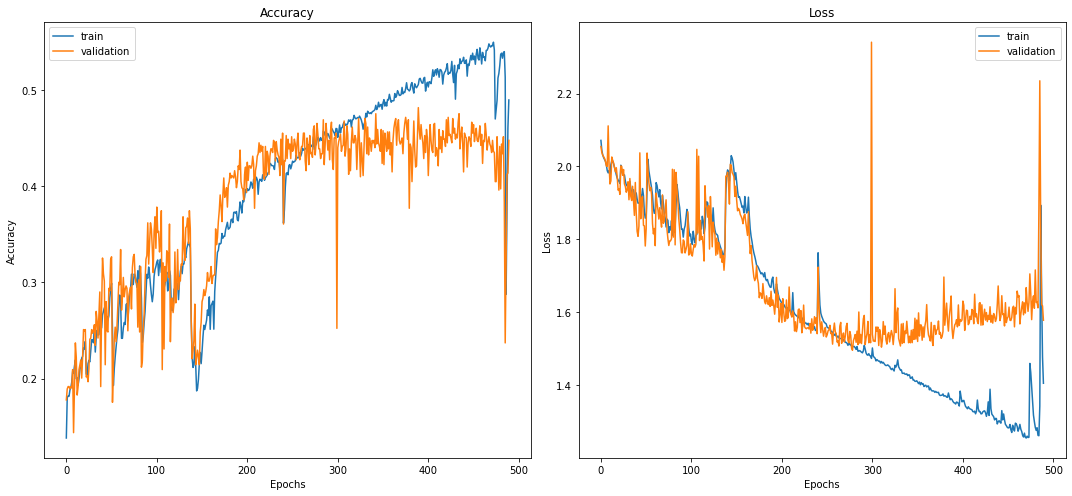

In [8]:
plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')

plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [9]:
y_pred=np.argmax(model.predict(X_test), axis=-1)
print('Classification Report (test set)')
print(classification_report(y_test,y_pred))

Classification Report (test set)
              precision    recall  f1-score   support

           0       0.50      0.27      0.35        96
           1       0.26      0.17      0.21        98
           2       0.22      0.23      0.23       100
           3       0.53      0.61      0.56       100
           4       0.33      0.33      0.33       100
           5       0.36      0.28      0.32       100
           6       0.27      0.31      0.29       100
           7       0.34      0.57      0.43       100

    accuracy                           0.35       794
   macro avg       0.35      0.35      0.34       794
weighted avg       0.35      0.35      0.34       794



The LSTM performs about the same as the CNN, both with accuracy of 38%. It takes the LSTM about 300 epochs for the validation accuracy and the training set accuracy to diverge, where the CNN only takes about 5 epochs.

| Model | Accuracy(all classes) | Train Time |
| --- | --- | --- |
| CNN | .38 | 3m 30s |
| LSTM | .38 | 110m |


It may be useful to combine features of the two models and see if we can achieve better results. I will implement a Time Dstributed Convolutional model in the next notebook.